In [1]:
from math import exp, sqrt, pi, pow
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats

from consts import default_random_seed, y1_dist_param_default, y0_dist_param_default
from sample_generation import create_sample
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, plot_pi_h, calculate_integral_bounds, \
    calculate_integral, plot_pi_h_and_bounds

random.seed(default_random_seed)

# $Y(t)|X,S_t=1$


In [2]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
print("\nExample from each strata:")
sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1)


Example from each strata:


,x,t,D0,D1,stratum,S1,S0,Y0,Y1,D_obs,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
577,0.853175,1,0,0,AS,1.0,1.0,11.855714,14.605814,0,...,11.706351,13.412701,1,1,0.0,2.0,10.0,0.0,4.0,10.0
658,0.291834,0,0,0,AS,1.0,1.0,9.383971,11.009591,0,...,10.583669,11.167338,1,1,0.0,2.0,10.0,0.0,4.0,10.0
220,0.315226,1,0,0,AS,1.0,1.0,9.665746,11.182672,0,...,10.630452,11.260903,1,1,0.0,2.0,10.0,0.0,4.0,10.0
789,0.894567,1,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
506,0.821854,1,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
431,0.523021,1,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
55,0.843748,0,0,1,H,NaN,0.0,1.010502,NaN,0,...,1.687497,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
407,-0.978325,1,0,1,H,NaN,0.0,-1.481219,NaN,1,...,-1.956649,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
444,0.625599,1,0,1,H,NaN,0.0,1.564330,NaN,1,...,1.251198,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
736,-0.215110,0,1,0,P,0.0,NaN,NaN,-0.364634,1,...,NaN,-0.860439,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:

1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 1. Zhang & Rubin

#### Non parametric

In [3]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-2.0912030387305185, -0.050238004648200274]
Actual AS treatment effect: -0.19863522085628715


#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=1,D=0}},1\right]} \right]$<br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=1,D=0}}\right]} \right]$ <br><br>

$\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow \int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot f_{Y|X}(y|x)\,dy = \int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,dy$<br><br>

$\mu_{y_{(1)}}=E[Y|T=1,X=x]$ <br>
Let us assume that: $\mu_{y_{(1)}}=E[Y|T=1,X=x]:=\bar{\beta}_0+\bar{\beta_1} x$.
Then when can estimate the $\bar{\beta}_i$s and assign this linear equation as $\mu_{y_{(1)}}$ (It didn't have to be linear, it could have been polynomila, NN, anything). <br> <br> <br>

 $\int_{\Phi^{-1}(0)}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,dy$
  <br>
$\hat{y}=y-\mu_{Y_{(1)}} \overset{\frac{d\hat{y}}{dy}=\frac{d}{dy}(y-\mu_{Y_{(1)}})=1}{\longrightarrow} d\hat{y}=dy$
  <br><br>
$\Longrightarrow\int_{\Phi^{-1}(0)}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} \overbrace{y}^{\hat{y}+\mu_{Y_{(1)}}}\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\overbrace{y-\mu_{Y_{(1)}}}^{=\hat{y}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\overbrace{dy}^{d\hat{y}} =$
$\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\hat{y}+\mu_{Y_{(1)}})\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\hat{y}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,d\hat{y} = $
$\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\hat{y}+\mu_{Y_{(1)}})\cdot\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\hat{y}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\frac{d\hat{y}}{\sigma_{Y_{(1)}}}
$
<br><br>
$\tilde{y}=\hat{y}/\sigma_{Y_{(1)}}\overset{\frac{d\tilde{y}}{d\hat{y}}=\frac{d}{d\hat{y}}\hat{y}/\sigma_{Y_{(1)}}=1/\sigma_{Y_{(1)}}}{\longrightarrow}d\tilde{y}=\frac{d\hat{y}}{\sigma_{Y_{(1)}}}$
<br><br>
$\Longrightarrow 
\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\overbrace{\hat{y}}^{\tilde{y}\sigma_{Y_{(1)}}}+\mu_{Y_{(1)}})\cdot\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\overbrace{\frac{\hat{y}}{\sigma_{Y_{(1)}}}}^{\tilde{y}}\right)^{2}\,\right)\,\overbrace{\frac{d\hat{y}}{\sigma_{Y_{(1)}}}}^{d\tilde{y}}=$
$\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (\tilde{y}\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\underbrace{\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\tilde{y}^{2}\,\right)}_{\text{pdf of s.n.}}\,d\tilde{y}
$

<br><br><br>
$\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\Phi^{-1}\frac{\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (\tilde{y}\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\underbrace{\varphi(\tilde{y})}_{\text{pdf of s.n.}}\,d\tilde{y} \right) $<br><br><br>

Therefor bounds are:<br>
Lower bound:
$min_{\pi_h}\left[ \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (y\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\varphi(y)\,dy \right)  - \left(\int_{\frac{\Phi^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi^{-1}(1)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}} (y\sigma_{Y_{(0)}}+\mu_{Y_{(0)}})\cdot\varphi(y)\,dy \right)\right]$<br>
Upper bound:
$max_{\pi_h}\left[ \left(\int_{\frac{\Phi^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}(1)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (y\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\varphi(y)\,dy \right)  - \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}} (y\sigma_{Y_{(0)}}+\mu_{Y_{(0)}})\cdot\varphi(y)\,dy \right) \right]$
<br><br><br>

$P_{T=0,D=0}=\frac{\#\{D_i=0 \& T_i=0\}}{\#\{T_i=0\}}=p(D_i=0|T_i=0, X=x)= 1- \frac{1}{1+\exp\{(-{\beta_D}^\top [1,t=0,x])\}}=1- \frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}$<br>
$P_{T=1,D=0}=\frac{\#\{D_i=0 \& T_i=1\}}{\#\{T_i=1\}}=p(D_i=0|T_i=1, X=x)= 1- \frac{1}{1+\exp\{(-{\beta_D}^\top [1,t=1,x])\}}=1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}$<br>
$\pi_h: \max\left(0,\overbrace{1-\frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}}^{P_{T=0,D=0}} - \overbrace{1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}}^{P_{P_{T=1,D=0}}}\right)  \leq\pi_h\leq  \min\left(\overbrace{1-\frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}}^{P_{T=0,D=0}}, 1- \left( \overbrace{1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}}^{P_{T=1,D=0}}\right)\right)$

##### $\Phi^{-1}(\alpha)=P(Y<F^{-1}(\alpha))$, where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y$. <br>
First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### Parametric bounds calculation function

In [4]:
def calc_zhang_rubin_bounds_per_x(
    x: float, mu_y_0_x: float, mu_y_1_x: float, sigma_0: float, sigma_1:float,
    a0: float, b0: float, c0: float, a1: float, b1: float, c1: float,
    beta_d: List[float], plot_and_print: bool = False, pi_h_step: float = 0.001,
    calc_non_parametric = False) -> Tuple[float, float]:

    beta_d0, beta_d1, beta_d2 = beta_d
    # print(f"mu0: {mu_y_0_x}, mu1: {mu_y_1_x}, sigma0: {sigma_0}, sigma1: {sigma_1}, beta: {beta_d}")

    # pi
    p_t0d0 = 1-1/(1+exp(-beta_d0-beta_d2*x))
    p_t1d0 = 1-1/(1+exp(-beta_d0-beta_d1-beta_d2*x))
    lower_pi = max(0, p_t0d0-p_t1d0)
    upper_pi = min(p_t0d0, 1-p_t1d0)
    pi_h_list = np.arange(lower_pi, upper_pi + pi_h_step, pi_h_step)
    if plot_and_print:
        plot_pi_h(lower_pi, upper_pi)

    # bounds
    zhang_rubin_lb_results = []
    zhang_rubin_ub_results = []
    zhang_rubin_lb_non_parametric_results = []
    zhang_rubin_ub_non_parametric_results = []
    for pi_h in pi_h_list:
        # integrals = {
        # 'lb_frst_argmt_integral': {'lb': (special.ndtri(0)-mu_y_1_x)/sigma_1, 'ub': (special.ndtri(p_t0d0/p_t1d0-pi_h/p_t1d0)-mu_y_1_x)/sigma_1, 'mu':mu_y_1_x , 'sigma':sigma_1},
        # 'lb_scnd_argmt_integral': {'lb': (special.ndtri(pi_h/p_t1d0)-mu_y_0_x)/sigma_0, 'ub': (special.ndtri(1)-mu_y_0_x)/sigma_0, 'mu':mu_y_0_x , 'sigma':sigma_0}, #for pi_h=0, this is integral from phi(one) to phi(one)-> from inf to inf, returns nan
        # 'ub_frst_argmt_integral': {'lb': (special.ndtri(1-p_t0d0/p_t1d0+pi_h/p_t1d0)-mu_y_1_x)/sigma_1,'ub': (special.ndtri(1)-mu_y_1_x)/sigma_1, 'mu':mu_y_1_x , 'sigma':sigma_1},
        # 'ub_scnd_argmt_integral': {'lb': (special.ndtri(0)-mu_y_0_x)/sigma_0,'ub': (special.ndtri(1-pi_h/p_t1d0)-mu_y_0_x)/sigma_0, 'mu':mu_y_0_x , 'sigma':sigma_0}
        # }


        # Y1
        mu_1_as = a1 + b1*x + c1
        mu_1_p = a1 + b1*x
        # QUESTION: Where do we account for the fact that this x resulted in EITHER AS or P? we don't have another x like this with the opposite strata. We are taking weighted average but where does the probability of being AS/P - in terms of Beta - is addressed?

        f1 = stats.norm(loc=mu_1_as, scale=sigma_1)
        f2 = stats.norm(loc=mu_1_p, scale=sigma_1)
        component_distributions = [f1,f2]
        weight = p_t0d0/p_t1d0-pi_h/p_t1d0
        ps = [weight, 1-weight]
        alpha_list = [0, p_t0d0/p_t1d0-pi_h/p_t1d0, 1-p_t0d0/p_t1d0+pi_h/p_t1d0, 1]
        
        frst_argmt_integral_list = calculate_integral_bounds(component_distributions, weight, ps, alpha_list, mu_y_1_x, sigma_1)
        lb_frst_argmt_integral_lb, lb_frst_argmt_integral_ub, ub_frst_argmt_integral_lb, ub_frst_argmt_integral_ub = frst_argmt_integral_list


        # Y0
        mu_0_as = a0 + b0*x + c0
        mu_0_h = a0 + b0*x
        # QUESTION: Where do we account for the fact that this x resulted in EITHER AS or P? we don't have another x like this with the opposite strata. We are taking weighted average but where does the probability of being AS/P - in terms of Beta - is addressed?

        f1 = stats.norm(loc=mu_0_as, scale=sigma_0)
        f2 = stats.norm(loc=mu_0_h, scale=sigma_0)
        component_distributions = [f1,f2]
        weight = p_t0d0-pi_h/p_t0d0
        ps = [weight, 1-weight]
        alpha_list = [pi_h/p_t1d0, 1, 0, 1-pi_h/p_t1d0]

        scnd_argmt_integral_list = calculate_integral_bounds(component_distributions, weight, ps, alpha_list, mu_y_0_x, sigma_0)
        lb_scnd_argmt_integral_lb, lb_scnd_argmt_integral_ub, ub_scnd_argmt_integral_lb, ub_scnd_argmt_integral_ub = scnd_argmt_integral_list



        integrals = {
        'lb_frst_argmt_integral': {'lb': lb_frst_argmt_integral_lb, 'ub': lb_frst_argmt_integral_ub, 'mu':mu_y_1_x , 'sigma':sigma_1},
        'lb_scnd_argmt_integral': {'lb': lb_scnd_argmt_integral_lb, 'ub': lb_scnd_argmt_integral_ub, 'mu':mu_y_0_x , 'sigma':sigma_0},
        'ub_frst_argmt_integral': {'lb': ub_frst_argmt_integral_lb, 'ub': ub_frst_argmt_integral_ub, 'mu':mu_y_1_x , 'sigma':sigma_1},
        'ub_scnd_argmt_integral': {'lb': ub_scnd_argmt_integral_lb, 'ub': ub_scnd_argmt_integral_ub, 'mu':mu_y_0_x , 'sigma':sigma_0}
        }



        for k in integrals.keys():
            lb = integrals[k]['lb']
            ub = integrals[k]['ub']
            integrals[k]['result'] = calculate_integral(lambda y: (y * integrals[k]['sigma'] + integrals[k]['mu']) * 1/(sqrt(2*pi)) * exp(-1/2 * pow(y,2)), lb, ub) # if lb!=ub else 0
            
        
        zhang_rubin_lb = integrals['lb_frst_argmt_integral']['result'] - integrals['lb_scnd_argmt_integral']['result']
        zhang_rubin_ub = integrals['ub_frst_argmt_integral']['result'] - integrals['ub_scnd_argmt_integral']['result']
        if plot_and_print:
            print(f"""pi_h {round(pi_h,3)}:
            LB: 1st intagral: {round(integrals['lb_frst_argmt_integral']['lb'],2)} to {round(integrals['lb_frst_argmt_integral']['ub'],2)}. 2nd intagral: {integrals['lb_scnd_argmt_integral']['lb']} to {round(integrals['lb_scnd_argmt_integral']['ub'],2)}.
            UB: 1st intagral: {round(integrals['ub_frst_argmt_integral']['lb'],2)} to {round(integrals['ub_frst_argmt_integral']['ub'],2)}. 2nd intagral: {integrals['ub_scnd_argmt_integral']['lb']} to {round(integrals['ub_scnd_argmt_integral']['ub'],2)}. 
            Zhang and Rubin bounds are [{zhang_rubin_lb}, {zhang_rubin_ub}]
            """)
        zhang_rubin_lb_results.append(zhang_rubin_lb)
        zhang_rubin_ub_results.append(zhang_rubin_ub)


    zhang_rubin_lb = np.nanmin(zhang_rubin_lb_results)
    zhang_rubin_ub = np.nanmax(zhang_rubin_ub_results)
    
    if plot_and_print:
        print(f"mu_y_1_x-mu_y_0_x: {mu_y_1_x-mu_y_0_x}")
        print(f"Zhang and Rubins bounds: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
        if calc_non_parametric:
            zhang_rubin_lb_non_parametric, zhang_rubin_ub_non_parametric = calc_non_parametric_zhang_rubin(create_sample(x_dist=x))
            print(f"Zhang and Rubins non parametric bounds: [{zhang_rubin_lb_non_parametric}, {zhang_rubin_ub_non_parametric}]")
        plot_pi_h_and_bounds(pi_h_list, zhang_rubin_lb_results, zhang_rubin_ub_results)
    
    return (zhang_rubin_lb, zhang_rubin_ub) 

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [5]:
# def pi_h_and_bounds_plots_controller(df: pd.DataFrame) -> None:
#     df_for_analysis = df.sample(n=40, random_state=1).sort_values(by="x")
#     for i,row in df_for_analysis.iterrows():
#         print(f"x is: {round(row.x,2)}")
#         calc_non_parametric = not(i % 10)
#         if calc_non_parametric:
#             print("** including the non parametric bounds **")
#         calc_zhang_rubin_bounds_per_x(x=row.x, plot_and_print=True, mu_y_0_x=row.mu0, mu_y_1_x=row.mu1, sigma_0=row.sigma_0, sigma_1=row.sigma_1, a0=row.a0, b0=row.b0, c0=row.c0, a1=row.a1, b1=row.b1, c1=row.c1, beta_d=row.beta_d, calc_non_parametric=calc_non_parametric)
#     # zr_as_cate_bound_for_given_x = calc_zhang_rubin_bounds_per_x(x=0.0065, plot_and_print=True, beta_d = [5.0, -10.0, 6.0])
#
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [6]:
def calc_zhang_rubin_bounds(df: pd.DataFrame) -> List[Tuple[float, float]]:
    list_of_bounds = list()
    for index, row in df.iterrows():
        if index%10000==0:
            print(f"row {index} out of {df.shape[0]}")
        bound = calc_zhang_rubin_bounds_per_x(x=row.x, mu_y_0_x=row.mu0, mu_y_1_x=row.mu1, sigma_0=row.sigma_0, sigma_1=row.sigma_1,  a0=row.a0, b0=row.b0, c0=row.c0, a1=row.a1, b1=row.b1, c1=row.c1, beta_d=row.beta_d, pi_h_step=0.01)
        list_of_bounds.append(bound)
    return list_of_bounds

In [7]:
def plot_zhang_rubin_bounds(df: pd.DataFrame, zhang_rubin_bounds: List[Tuple[float, float]],
                            y0_dist_param: Dict[str, float] = y0_dist_param_default,
                            y1_dist_param: Dict[str, float] = y1_dist_param_default):


    df_plot_as = df.loc[df.stratum==Strata.AS.name]    
    plt.scatter(df_plot_as.x, (df_plot_as.Y1 - df_plot_as.Y0), label = "True Y1 - Y0|AS" , s=0.1)
    

    mu_y_0_x = df.mu0
    mu_y_1_x = df.mu1

    lb, up = zip(*zhang_rubin_bounds)
    print(f"lower bound: {lb}, upper bound: {up}, true value: {mu_y_1_x-mu_y_0_x}")
    plt.scatter(list(df.x), lb, label = "Lower bound", s=0.1)
    plt.scatter(list(df.x), up, label = "Upper bound", s=0.1)
    plt.scatter(list(df.x), mu_y_1_x-mu_y_0_x, label = r'$\mu_{y(1)|x}-\mu_{y(0)|x}$', s=0.1)

    plt.legend(markerscale=12)
    # plt.legend()
    plt.title("Bounding Y1-Y0|AS by Zhang and Rubin")
    plt.xlabel('X')
    plt.ylabel('Y1-Y0|AS bounds')
    plt.ylim((min(-3,min(lb)),max(3,max(up))))
    plt.show()
    return {'lb': lb, 'up': up, 'true value': mu_y_1_x-mu_y_0_x}

In [8]:
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0]
zhang_rubin_bounds = calc_zhang_rubin_bounds(sample_for_y_dist_s)

row 0 out of 927


/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/zhang_rubin_help_func.py:157: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_result, estimate_absolute_error = integrate.quad(func, lower_limit_integration, upper_limit_integration)
/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: All-NaN axis encountered
/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: All-NaN axis encountered


lower bound: (1.8414861104214908e-16, -1.5163925563853798e-27, nan, -2.564409481914486e-21, 1.0333630762662187e-10, 1.0346710591224652e-10, 1.2777757609506007e-08, -5.684374191365923e-26, -2.336771066989538e-21, -3.6794022286905157e-23, 6.835360566161613e-08, -6.554959521714611e-28, nan, 4.3970998272009e-12, 2.6109489052063407e-11, 2.3966240771071682e-11, 1.8532981482229994e-14, nan, 2.416209460880133e-18, 4.1675142820109493e-14, nan, 2.4359643511113296e-10, nan, 3.224759378227668e-16, 1.330882233856842e-19, -1.6459560604319763e-24, 9.822369226634924e-12, nan, -3.245935864086755e-21, 2.171124822967362e-08, -1.830993604288849e-21, 4.795279029131183e-11, 9.261919284392213e-09, -7.906117941270684e-28, -6.338581349429165e-25, 1.810585918329829e-14, 1.967662332459465e-09, -9.433528165935995e-23, 1.117396366027865e-18, 5.908624683800869e-10, -8.622092952100063e-20, 3.726673365395619e-08, -9.070208872860023e-27, 2.983375635075992e-13, -2.206080853132294e-22, 1.1575223641824692e-14, -4.3362725

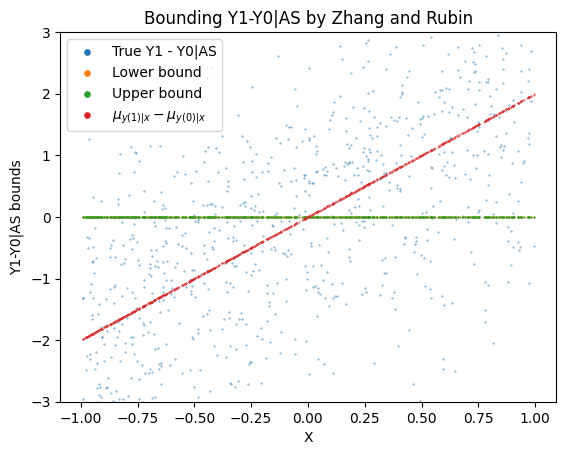

In [9]:
d = plot_zhang_rubin_bounds(sample_for_y_dist_s, zhang_rubin_bounds)

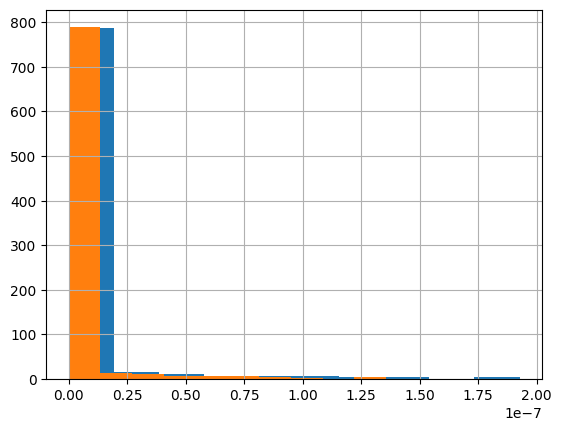

In [10]:
pd.Series(d['up']).hist()
pd.Series(d['lb']).hist()

In [11]:
# check that the bounds are bounding the expected value correctly
for i,true in enumerate(d['true value']):
    if true>d['up'][i] or true<d['lb'][i]:
        print(f"bad {i}")


bad 0
bad 1
bad 3
bad 4
bad 5
bad 6
bad 7
bad 8
bad 9
bad 10
bad 11
bad 13
bad 14
bad 15
bad 16
bad 18
bad 19
bad 21
bad 23
bad 24
bad 25
bad 26
bad 28
bad 29
bad 30
bad 31
bad 32
bad 33
bad 34
bad 35
bad 36
bad 37
bad 38
bad 39
bad 40
bad 41
bad 42
bad 43
bad 44
bad 45
bad 46
bad 47
bad 48
bad 49
bad 50
bad 51
bad 53
bad 55
bad 56
bad 57
bad 58
bad 59
bad 60
bad 62
bad 63
bad 64
bad 65
bad 66
bad 67
bad 68
bad 69
bad 70
bad 71
bad 73
bad 74
bad 75
bad 76
bad 77
bad 78
bad 79
bad 80
bad 81
bad 82
bad 83
bad 85
bad 86
bad 88
bad 89
bad 90
bad 91
bad 92
bad 93
bad 94
bad 95
bad 96
bad 97
bad 98
bad 99
bad 101
bad 102
bad 104
bad 105
bad 106
bad 107
bad 109
bad 110
bad 111
bad 112
bad 113
bad 115
bad 117
bad 119
bad 120
bad 121
bad 122
bad 123
bad 124
bad 125
bad 126
bad 127
bad 128
bad 129
bad 130
bad 131
bad 132
bad 135
bad 136
bad 137
bad 138
bad 139
bad 140
bad 141
bad 142
bad 143
bad 144
bad 145
bad 146
bad 147
bad 148
bad 149
bad 150
bad 151
bad 152
bad 153
bad 154
bad 155
bad 156
b

In [ ]:
# d['x']=sample_for_y_dist.x
# pd.DataFrame(d)
# pd.DataFrame(d).lb.min()